In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4 as nc
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker

In [2]:
data = pd.read_csv("global.1751_2014.csv")
data_conv = data.iloc[:, :2]
data_conv_dr = data_conv.drop(0)
data_conv_dr

,Year,Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)
1,1751,3
2,1752,3
3,1753,3
4,1754,3
5,1755,3
...,...,...
260,2010,9128
261,2011,9503
262,2012,9673
263,2013,9773


In [3]:
# 1.1 
# I've got great help from my friend yuguang Zhu.

# Make sure the emission column is of floating point type and directly converted to pgc
data_conv_dr['PGC'] = data_conv_dr['Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)'].astype(float).apply(lambda x: x * 1e12 / 1e15)

# Create a new DataFrame containing a specific row
ppm_df = data_conv_dr[['Year', 'PGC']].loc[237:254]


ppm_df

,Year,PGC
237,1987,5.725
238,1988,5.936
239,1989,6.066
240,1990,6.074
241,1991,6.142
242,1992,6.078
243,1993,6.070
244,1994,6.174
245,1995,6.305
246,1996,6.448


In [4]:
# Initialize the variable to store the result
calculation_without_buffer = []


N1 = 740  # Carbon concentration in the atmosphere
N2 = 900  # Carbon concentration at the ocean surface
k12 = 105 / 740  # Atmosphere-to-ocean transfer coefficient 
k21 = 102 / 900  # Ocean-to-atmosphere transfer coefficient
# I wonder the coefficient is a fixed value or it changes with the different carbon concentration in the atmosphere and ocean each year?


# Ensure that the length of years matches the number of lines in ppm_df_need
num_years = len(ppm_df)


for i in range(num_years):
    year = ppm_df['Year'].iloc[i]
    gamma = ppm_df['PGC'].iloc[i]

    dN1_dt = -k12 * N1 + k21 * N2 + gamma
    dN2_dt = k12 * N1 - k21 * N2
    
    
    dt = 1  
    N1 += dN1_dt * dt
    N2 += dN2_dt * dt

    
    calculation_without_buffer.append(N1 / 2.13)

   
    print(f"Year: {year}, Atmospheric CO2 concentration: {N1 / 2.13:.2f} ppm")



Year: 1987, Atmospheric CO2 concentration: 348.70 ppm
Year: 1988, Atmospheric CO2 concentration: 350.05 ppm
Year: 1989, Atmospheric CO2 concentration: 351.44 ppm
Year: 1990, Atmospheric CO2 concentration: 352.80 ppm
Year: 1991, Atmospheric CO2 concentration: 354.17 ppm
Year: 1992, Atmospheric CO2 concentration: 355.48 ppm
Year: 1993, Atmospheric CO2 concentration: 356.78 ppm
Year: 1994, Atmospheric CO2 concentration: 358.12 ppm
Year: 1995, Atmospheric CO2 concentration: 359.51 ppm
Year: 1996, Atmospheric CO2 concentration: 360.95 ppm
Year: 1997, Atmospheric CO2 concentration: 362.41 ppm
Year: 1998, Atmospheric CO2 concentration: 363.86 ppm
Year: 1999, Atmospheric CO2 concentration: 365.28 ppm
Year: 2000, Atmospheric CO2 concentration: 366.77 ppm
Year: 2001, Atmospheric CO2 concentration: 368.31 ppm
Year: 2002, Atmospheric CO2 concentration: 369.87 ppm
Year: 2003, Atmospheric CO2 concentration: 371.59 ppm
Year: 2004, Atmospheric CO2 concentration: 373.43 ppm


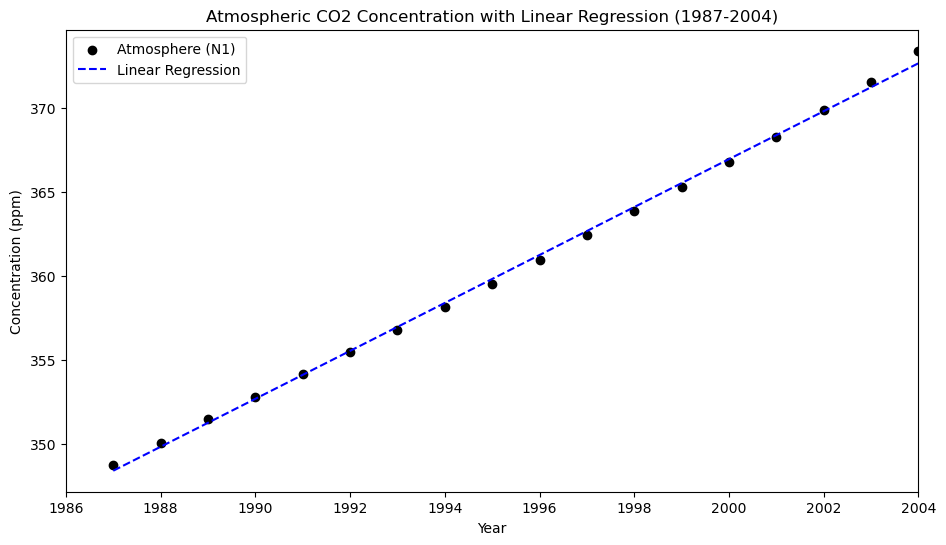

In [14]:
years = np.arange(1987, 2005, 1)

co2_concentration = np.array(calculation_without_buffer).reshape(-1, 1)

# Convert year and CO2 concentration data into NumPy arrays for linear regression
X = years.reshape(-1, 1)  # Convert to a two-dimensional array to fit sklearn's API
y = co2_concentration


regressor = LinearRegression()
regressor.fit(X, y)


predicted_co2 = regressor.predict(X)


plt.figure(figsize=(11, 6))
plt.scatter(X, y, label='Atmosphere (N1)',color='black')
plt.plot(X, predicted_co2, color='blue', linestyle='--', label='Linear Regression')
plt.xlabel('Year')
plt.ylabel('Concentration (ppm)')
plt.xlim(1986, 2004)
plt.title('Atmospheric CO2 Concentration with Linear Regression (1987-2004)')
plt.legend()
plt.show()



In [6]:
# 1.2
 
calculation_with_buffer = []

N1 = 740  
N2 = 900  
k12 = 105 / 740  
k21 = 102 / 900  
N20 = 821  # The balance of ocean surface carbon


for i in range(num_years):
    year = ppm_df['Year'].iloc[i]
    gama = ppm_df['PGC'].iloc[i]
    z = N1 / 2.13  # Atmospheric CO2 concentration in parts per million

    # Calculate the buffer factor
    xi = 3.69 + 1.86 * 10**(-2) * z - 1.80 * 10**(-6) * z**2

    dN1_dt = -k12 * N1 + k21 * (N20 + xi * (N2 - N20)) + gama
    dN2_dt = k12 * N1 - k21 * (N20 + xi * (N2 - N20))

   
    dt = 1  
    N1 += dN1_dt * dt
    N2 += dN2_dt * dt


    calculation_with_buffer.append(N1 / 2.13)

    
    print(f"Year: {year}, Atmospheric CO2 concentration: {N1 / 2.13:.2f} ppm")



Year: 1987, Atmospheric CO2 concentration: 386.25 ppm
Year: 1988, Atmospheric CO2 concentration: 379.05 ppm
Year: 1989, Atmospheric CO2 concentration: 384.78 ppm
Year: 1990, Atmospheric CO2 concentration: 386.37 ppm
Year: 1991, Atmospheric CO2 concentration: 389.31 ppm
Year: 1992, Atmospheric CO2 concentration: 391.79 ppm
Year: 1993, Atmospheric CO2 concentration: 394.41 ppm
Year: 1994, Atmospheric CO2 concentration: 397.03 ppm
Year: 1995, Atmospheric CO2 concentration: 399.73 ppm
Year: 1996, Atmospheric CO2 concentration: 402.49 ppm
Year: 1997, Atmospheric CO2 concentration: 405.30 ppm
Year: 1998, Atmospheric CO2 concentration: 408.11 ppm
Year: 1999, Atmospheric CO2 concentration: 410.92 ppm
Year: 2000, Atmospheric CO2 concentration: 413.81 ppm
Year: 2001, Atmospheric CO2 concentration: 416.77 ppm
Year: 2002, Atmospheric CO2 concentration: 419.77 ppm
Year: 2003, Atmospheric CO2 concentration: 422.95 ppm
Year: 2004, Atmospheric CO2 concentration: 426.29 ppm


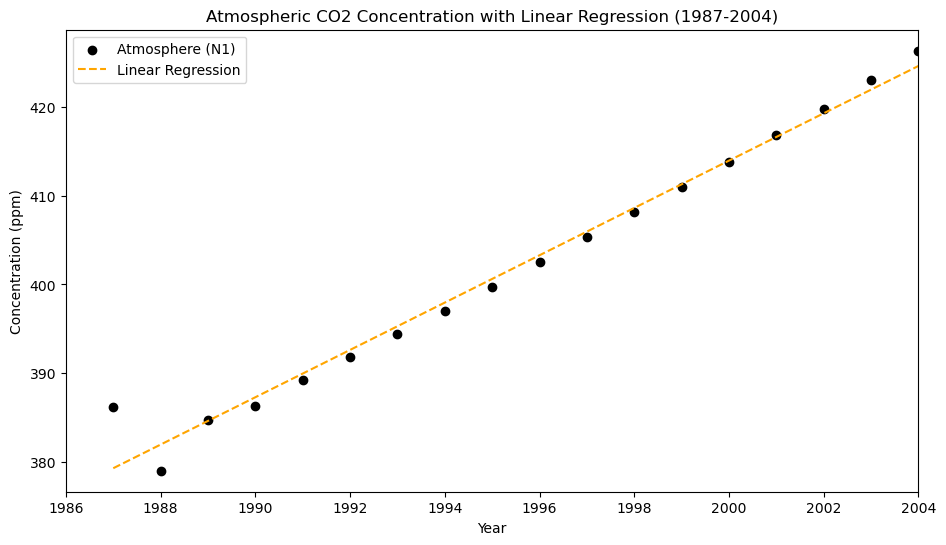

In [15]:
years = np.arange(1987, 2005, 1)


co2_concentration_2 = np.array(calculation_with_buffer).reshape(-1, 1)


X_2 = years.reshape(-1, 1)  
y_2 = co2_concentration_2


regressor = LinearRegression()
regressor.fit(X_2, y_2)


predicted_co2_2 = regressor.predict(X_2)


plt.figure(figsize=(11, 6))
plt.scatter(X_2, y_2, label='Atmosphere (N1)',color='black')
plt.plot(X_2, predicted_co2_2, color='orange', linestyle='--', label='Linear Regression')
plt.xlabel('Year')
plt.ylabel('Concentration (ppm)')
plt.xlim(1986, 2004)
plt.title('Atmospheric CO2 Concentration with Linear Regression (1987-2004)')
plt.legend()
plt.show()

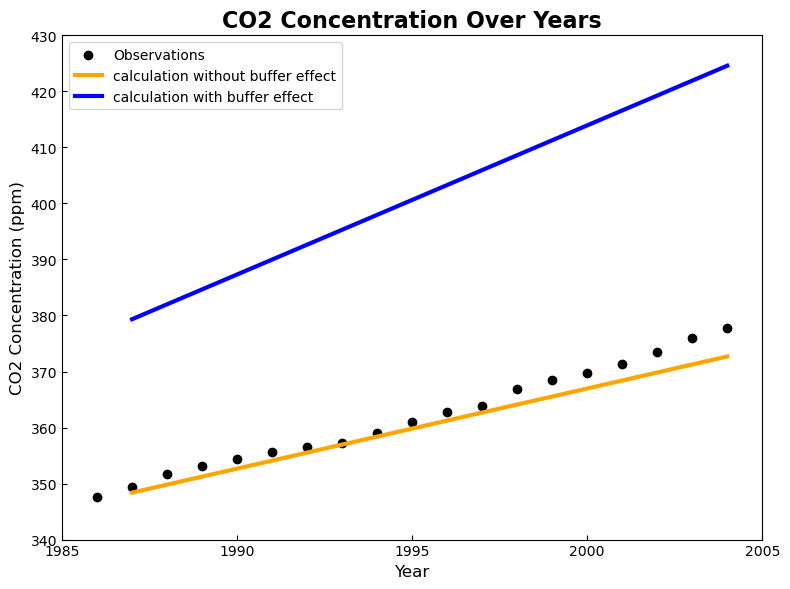

In [8]:
# 1.3

data = pd.read_csv('co2_annmean_mlo.csv', comment='#')

# Filter data from 1986 to 2004
filtered_data = data[(data['year'] >= 1986) & (data['year'] <= 2004)]

# Obtain filtered year and CO2 concentration data
years_with_1986 = filtered_data['year']
observations_with_1986 = filtered_data['mean']

plt.figure(figsize=(8, 6))
plt.scatter(years_with_1986, observations_with_1986, color='black', label='Observations')
plt.plot(X, predicted_co2, color='orange', linestyle='-', label='calculation without buffer effect', linewidth=3)
plt.plot(X_2, predicted_co2_2, color='blue', linestyle='-', label='calculation with buffer effect', linewidth=3)

# Set the scale to face in
plt.tick_params(axis='x', direction='in')
plt.tick_params(axis='y', direction='in', which='both')

# Set chart labels and titles
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 Concentration (ppm)', fontsize=12)
plt.title('CO2 Concentration Over Years', fontsize=16, fontweight='bold')

# Add grid
plt.grid(False)

# Set x-axis ticks with 5-year intervals
plt.xticks(np.arange(1985, 2006, 5))
plt.xlim(1985, 2005)
plt.ylim(340, 430)


plt.legend(fontsize=10)

plt.tight_layout()

plt.show()



In [9]:
# Bonus
# Again thanks to yuguang Zhu for the help.

co2_observations = pd.read_csv('1750-2000CO2.csv')
land_use_data = pd.read_excel('Global_land-use_flux-1750_2005.xls')
ff_emissions = pd.read_csv('global_1751_2016.csv')


land_use_data = land_use_data[['Year', 'Global']]
land_use_data['LandUseChange'] = land_use_data['Global'] / (1000 * 2.13)

ff_emissions = ff_emissions[['Year', 'Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)', 'Carbon emissions from cement production']]
ff_emissions['FossilFuelEmissions'] = ff_emissions.iloc[:, 1] - ff_emissions.iloc[:, 2]
ff_emissions['EmissionFactor'] = ff_emissions['FossilFuelEmissions'] / (1000 * 2.13)


In [10]:
k12, k21, k23, k24, k32, k34, k43, k45, k51, k67, k71 = [60 / 615, 60 / 842, 9 / 842, 43 / 842, 52 / 9744, 162 / 9744, 205 / 26280, 0.2 / 26280, 0.2 / 90000000, 62 / 731, 62 / 1238]
N2_0 = 842 / 2.13


initial_conditions = [615 / 2.13, 842 / 2.13, 9744 / 2.13, 26280 / 2.13, 90000000 / 2.13, 731 / 2.13, 1238 / 2.13]
f0 = 62 / 2.13
P0 = 615 / 2.13

# Explore the Beta value
beta_values = [0.38, 0.5]
results = []

for beta in beta_values:
    
    N1, N2, N3, N4, N5, N6, N7 = initial_conditions.copy()
    atmosphere = [N1]
    
    for year in range(1751, 2001):
        gamma = ff_emissions[ff_emissions['Year'] == year]['EmissionFactor'].values[0]
        delta = land_use_data[land_use_data['Year'] == year]['LandUseChange'].values[0]

        xi = 3.69 + 0.0186 * N1 - 0.0000018 * N1**2

        f = f0 * (1 + beta * np.log(N1 / P0))
        
        # Calculate the rate of change for each part
        dN1_dt = -k12 * N1 + k21 * (N2_0 + xi * (N2 - N2_0)) + gamma - f + delta + k51 * N5 + k71 * N7
        dN2_dt = k12 * N1 - k21 * (N2_0 + xi * (N2 - N2_0)) - k23 * N2 + k32 * N3 - k24 * N2
        dN3_dt = k23 * N2 - k32 * N3 - k34 * N3 + k43 * N4
        dN4_dt = k34 * N3 - k43 * N4 + k24 * N2 - k45 * N4
        dN5_dt = k45 * N4 - k51 * N5
        dN6_dt = f - k67 * N6 - 2 * delta
        dN7_dt = k67 * N6 - k71 * N7 + delta

        # Update the values of each section
        N1 += dN1_dt
        N2 += dN2_dt
        N3 += dN3_dt
        N4 += dN4_dt
        N5 += dN5_dt
        N6 += dN6_dt
        N7 += dN7_dt

        atmosphere.append(N1)

    results.append(atmosphere)


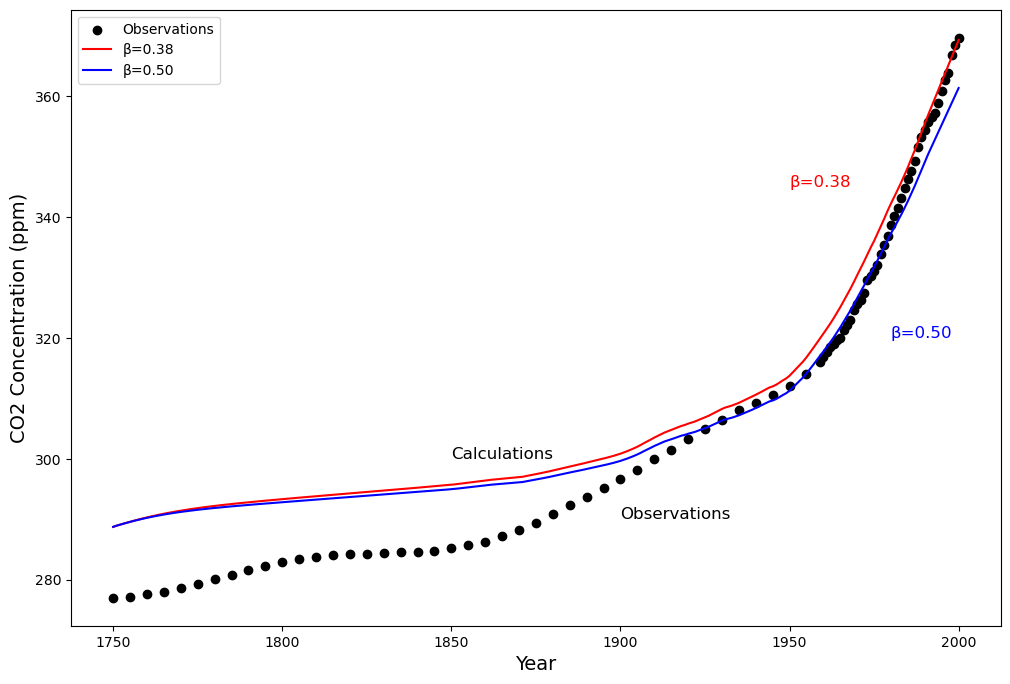

In [11]:
plt.figure(figsize=(12, 8))

plt.scatter(co2_observations['year'], co2_observations['mean'], label='Observations', color='black')

plt.text(1850, 300, 'Calculations', fontsize=12)
plt.text(1900, 290, 'Observations', fontsize=12)
plt.text(1950, 345, 'β=0.38', fontsize=12, color='red')
plt.text(1980, 320, 'β=0.50', fontsize=12, color='blue')

# Draw the results of each beta value directly, with the colors red and blue
plt.plot(range(1750, 2001), results[0], color='red', label='β=0.38')
plt.plot(range(1750, 2001), results[1], color='blue', label='β=0.50')


plt.xlabel('Year', fontsize=14)
plt.ylabel('CO2 Concentration (ppm)', fontsize=14)

plt.legend()

plt.show()

